In [1]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kaggle/kaggle.json ~/.kaggle/

In [2]:
!kaggle competitions download -c visual-taxonomy

 99%|██████████████████████████████████████▊| 3.50G/3.52G [00:15<00:00, 279MB/s]
100%|███████████████████████████████████████| 3.52G/3.52G [00:15<00:00, 247MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/working/visual-taxonomy.zip', 'r')
zip_ref.extractall('/kaggle/working/')
zip_ref.close()

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout

In [7]:
df = pd.read_csv('/kaggle/working/train.csv')
df.head()

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,NaN,NaN,NaN,NaN,NaN
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN


In [8]:
# Define the categories
categories = ['Men Tshirts', 'Sarees', 'Kurtis', 'Women Tshirts', 'Women Tops & Tunics']

# Loop through each category, filter rows, and save to a new CSV file
for category in categories:
    filtered_df = df[df['Category'] == category]
    filename = category.replace(" ", "_").replace("&", "and").lower() + '.csv'  # Format filename
    filtered_df.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(filtered_df)} rows.")


Saved men_tshirts.csv with 7267 rows.
Saved sarees.csv with 18346 rows.
Saved kurtis.csv with 6822 rows.
Saved women_tshirts.csv with 18774 rows.
Saved women_tops_and_tunics.csv with 19004 rows.


In [9]:
top = pd.read_csv('women_tops_and_tunics.csv')
top.head()

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,51375,Women Tops & Tunics,10,black,regular,NaN,NaN,NaN,NaN,NaN,NaN,regular sleeves,NaN
1,51376,Women Tops & Tunics,10,navy blue,fitted,crop,high,casual,default,solid,short sleeves,default,knitted
2,51377,Women Tops & Tunics,10,red,regular,regular,round neck,casual,printed,typography,sleeveless,sleeveless,NaN
3,51378,Women Tops & Tunics,10,default,fitted,crop,stylised,casual,solid,solid,short sleeves,regular sleeves,default
4,51379,Women Tops & Tunics,10,default,boxy,regular,round neck,casual,printed,typography,short sleeves,default,NaN


In [10]:
top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19004 entries, 0 to 19003
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19004 non-null  int64 
 1   Category  19004 non-null  object
 2   len       19004 non-null  int64 
 3   attr_1    14058 non-null  object
 4   attr_2    13337 non-null  object
 5   attr_3    13066 non-null  object
 6   attr_4    13451 non-null  object
 7   attr_5    12567 non-null  object
 8   attr_6    13217 non-null  object
 9   attr_7    13216 non-null  object
 10  attr_8    13797 non-null  object
 11  attr_9    12571 non-null  object
 12  attr_10   7181 non-null   object
dtypes: int64(2), object(11)
memory usage: 1.9+ MB


In [11]:
column_to_drop= ['len']
top = top.drop(column_to_drop,axis=1)

In [12]:
for i in top.columns:
  print(len(top[i].unique()),top[i].unique())

19004 [51375 51376 51377 ... 70376 70377 70378]
1 ['Women Tops & Tunics']
13 ['black' 'navy blue' 'red' 'default' 'maroon' 'white' nan 'green' 'blue'
 'pink' 'yellow' 'peach' 'multicolor']
5 ['regular' 'fitted' 'boxy' nan 'default']
3 [nan 'crop' 'regular']
8 [nan 'high' 'round neck' 'stylised' 'sweetheart neck' 'v-neck'
 'square neck' 'default']
3 [nan 'casual' 'party']
4 [nan 'default' 'printed' 'solid']
7 [nan 'solid' 'typography' 'graphic' 'default' 'quirky' 'floral']
5 [nan 'short sleeves' 'sleeveless' 'three-quarter sleeves' 'long sleeves']
5 ['regular sleeves' 'default' 'sleeveless' nan 'puff sleeves']
7 [nan 'knitted' 'default' 'ruffles' 'waist tie-ups' 'tie-ups' 'applique']


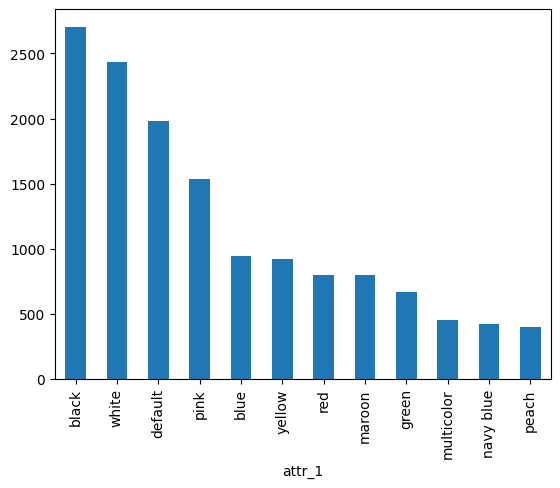

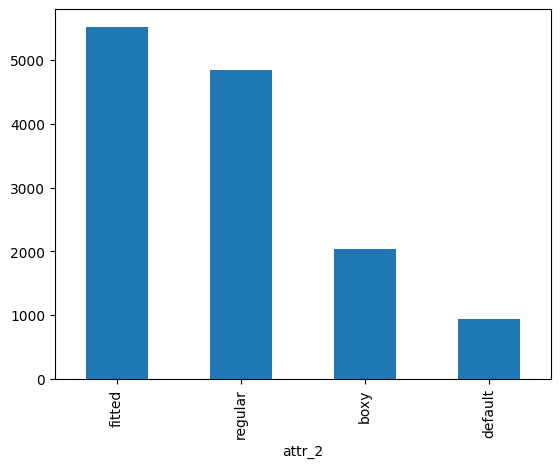

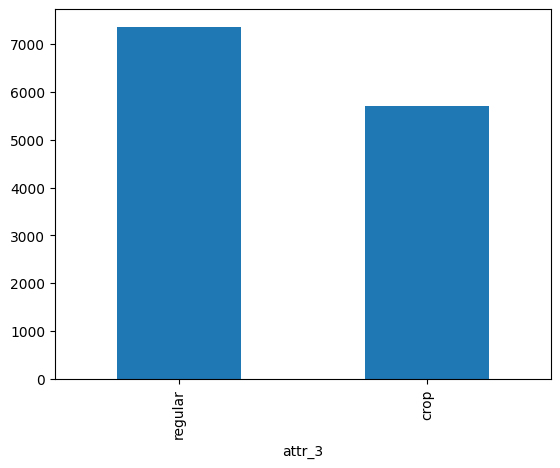

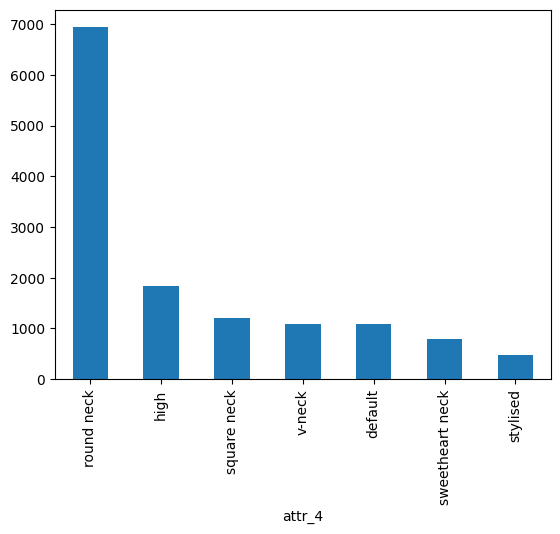

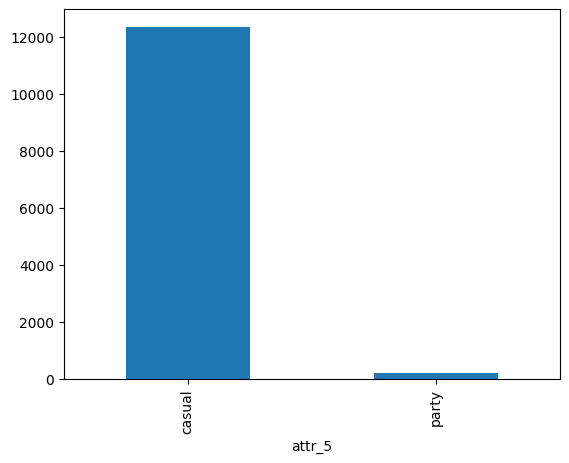

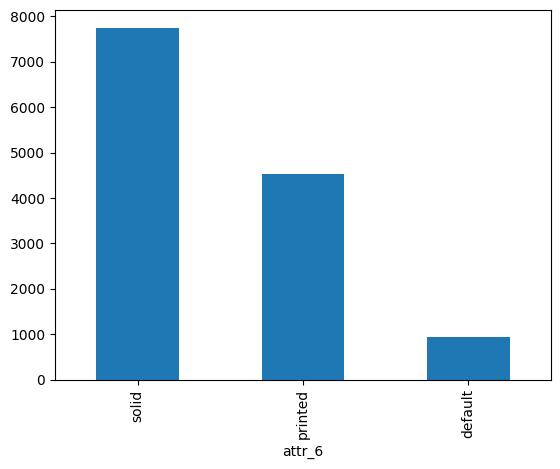

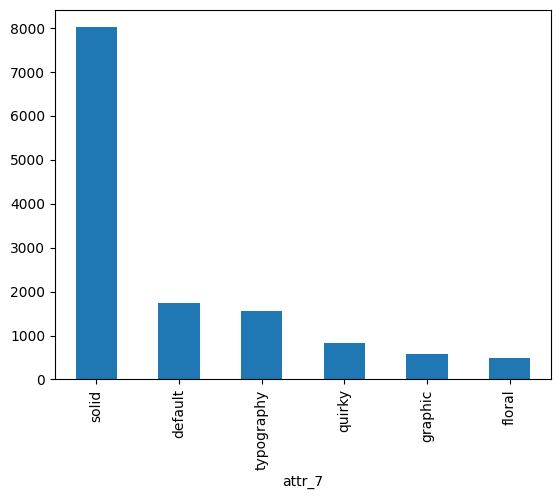

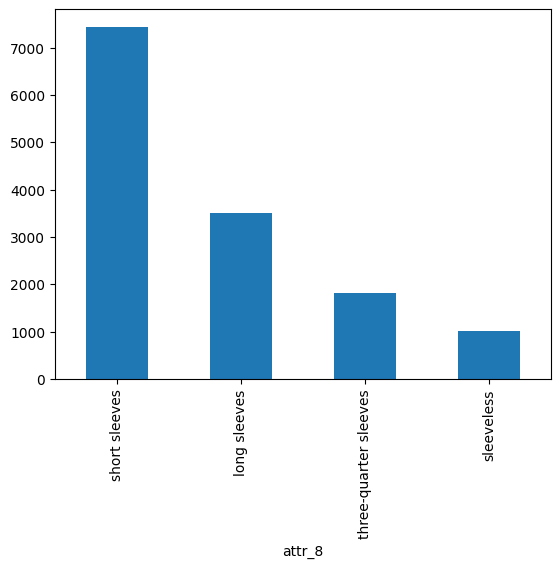

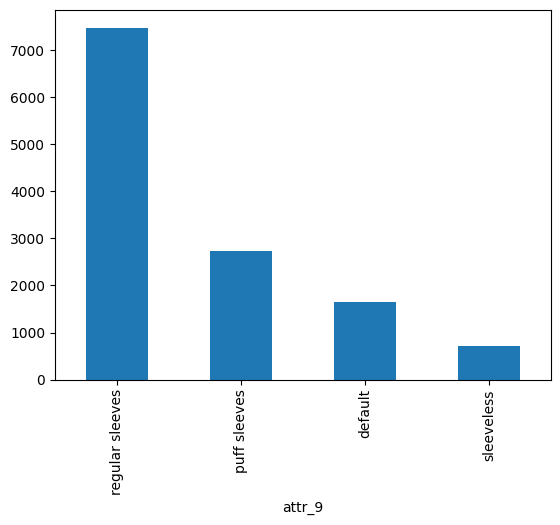

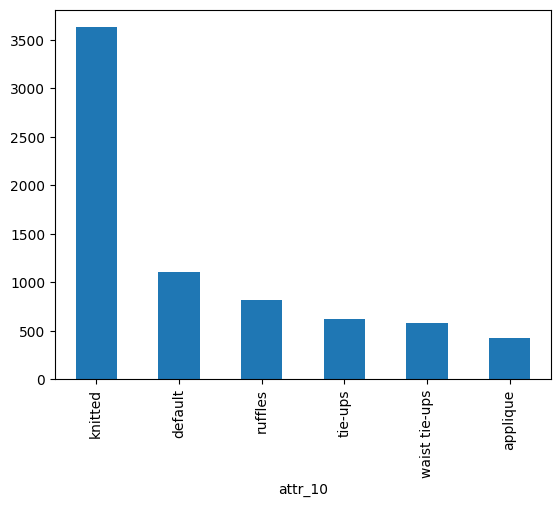

In [13]:
for i in top.columns:
  if (i!='id') and (i!='Category'):
    top[i].value_counts().plot(kind='bar')
    plt.show()

In [14]:
top.isnull().mean()*100

id           0.000000
Category     0.000000
attr_1      26.026100
attr_2      29.820038
attr_3      31.246053
attr_4      29.220164
attr_5      33.871816
attr_6      30.451484
attr_7      30.456746
attr_8      27.399495
attr_9      33.850768
attr_10     62.213218
dtype: float64

In [15]:
top['attr_1'].fillna('black',inplace=True)
top['attr_2'].fillna('fitted',inplace=True)
top['attr_3'].fillna('regular',inplace=True)
top['attr_4'].fillna('round neck',inplace=True)
top['attr_5'].fillna('casual',inplace=True)
top['attr_6'].fillna('solid',inplace=True)
top['attr_7'].fillna('solid',inplace=True)
top['attr_8'].fillna('short sleeves',inplace=True)
top['attr_9'].fillna('regular sleeves',inplace=True)
top['attr_10'].fillna('knitted',inplace=True)

/tmp/ipykernel_30/995709466.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  top['attr_1'].fillna('black',inplace=True)
/tmp/ipykernel_30/995709466.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [16]:
X5 = top.iloc[:,0:2]
y5 = top.iloc[:,2:]


In [17]:
for i in y5.columns:
  print(i,y5[i].unique(),len(y5[i].unique()))

attr_1 ['black' 'navy blue' 'red' 'default' 'maroon' 'white' 'green' 'blue'
 'pink' 'yellow' 'peach' 'multicolor'] 12
attr_2 ['regular' 'fitted' 'boxy' 'default'] 4
attr_3 ['regular' 'crop'] 2
attr_4 ['round neck' 'high' 'stylised' 'sweetheart neck' 'v-neck' 'square neck'
 'default'] 7
attr_5 ['casual' 'party'] 2
attr_6 ['solid' 'default' 'printed'] 3
attr_7 ['solid' 'typography' 'graphic' 'default' 'quirky' 'floral'] 6
attr_8 ['short sleeves' 'sleeveless' 'three-quarter sleeves' 'long sleeves'] 4
attr_9 ['regular sleeves' 'default' 'sleeveless' 'puff sleeves'] 4
attr_10 ['knitted' 'default' 'ruffles' 'waist tie-ups' 'tie-ups' 'applique'] 6


In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Correct the order of categories in the first column and add missing categories for others
oe = OrdinalEncoder(categories=[
    ['black', 'navy blue', 'red', 'default', 'maroon', 'white', 'green', 'blue', 'pink', 'yellow', 'peach', 'multicolor'],
    ['regular', 'fitted', 'boxy', 'default'],
    ['regular', 'crop'],
    ['round neck', 'high', 'stylised', 'sweetheart neck', 'v-neck', 'square neck', 'default'],
    [ 'casual','party'],
    ['solid', 'default', 'printed'],
    ['solid', 'typography', 'graphic', 'default', 'quirky', 'floral'],
    ['short sleeves', 'sleeveless', 'three-quarter sleeves', 'long sleeves'],
    ['regular sleeves', 'default', 'sleeveless', 'puff sleeves'],
    ['knitted', 'default', 'ruffles', 'waist tie-ups', 'tie-ups', 'applique']
])

y5 = oe.fit_transform(y5)


In [19]:
type(y5)

numpy.ndarray

In [20]:
from sklearn.model_selection import train_test_split
# Load images based on ID in the DataFrame
image_dir = '/kaggle/working/train_images'  # Adjust this path as necessary
max_digits = 6
#image_paths = [os.path.join(image_dir, f"{i}.jpg") for i in X['id']]
image_paths = [os.path.join(image_dir, f'{i:0{max_digits}}.jpg') for i in range(51375,70379)]
# Check if all images are accessible
for path in image_paths:
    if not os.path.exists(path):
        print(f"Missing image: {path}")


def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [128, 128])
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)


In [21]:
X5 = load_and_preprocess_images(image_paths)

In [38]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)

input_layer = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

#12 4 2 7 2 3 6 4 4 6
# Define output layers for 10 attributes
output_attr1 = Dense(12, activation='softmax', name='attr1_output')(x)
output_attr2 = Dense(4, activation='softmax', name='attr2_output')(x)
output_attr3 = Dense(2, activation='softmax', name='attr3_output')(x)
output_attr4 = Dense(7, activation='softmax', name='attr4_output')(x)
output_attr5 = Dense(2, activation='softmax', name='attr5_output')(x)
output_attr6 = Dense(3, activation='softmax', name='attr6_output')(x)
output_attr7 = Dense(6, activation='softmax', name='attr7_output')(x)
output_attr8 = Dense(4, activation='softmax', name='attr8_output')(x)
output_attr9 = Dense(4, activation='softmax', name='attr9_output')(x)
output_attr10 = Dense(6, activation='softmax', name='attr10_output')(x)

# Create model with 10 outputs
top = Model(inputs=input_layer, outputs=[
    output_attr1, output_attr2, output_attr3,
    output_attr4, output_attr5, output_attr6,
    output_attr7, output_attr8, output_attr9,
    output_attr10
])

opt = Adam(0.0002)
top.compile(optimizer=opt,
              loss={
                  'attr1_output': 'sparse_categorical_crossentropy',
                  'attr2_output': 'sparse_categorical_crossentropy',
                  'attr3_output': 'sparse_categorical_crossentropy',
                  'attr4_output': 'sparse_categorical_crossentropy',
                  'attr5_output': 'sparse_categorical_crossentropy',
                  'attr6_output': 'sparse_categorical_crossentropy',
                  'attr7_output': 'sparse_categorical_crossentropy',
                  'attr8_output': 'sparse_categorical_crossentropy',
                  'attr9_output': 'sparse_categorical_crossentropy',
                  'attr10_output': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'attr1_output': 'accuracy',
                  'attr2_output': 'accuracy',
                  'attr3_output': 'accuracy',
                  'attr4_output': 'accuracy',
                  'attr5_output': 'accuracy',
                  'attr6_output': 'accuracy',
                  'attr7_output': 'accuracy',
                  'attr8_output': 'accuracy',
                  'attr9_output': 'accuracy',
                  'attr10_output': 'accuracy'
              })

top.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 126, 126,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        128 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 63, 63,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 61, 61,    │     18,496 │ dropout_8[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 61, 61,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 59, 59,    │     73,856 │ dropout_9[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 59, 59,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 59, 59,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 445568)    │          0 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │ 57,032,832 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_11[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attr1_output        │ (None, 12)        │      1,548 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attr2_output        │ (None, 4)         │        516 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 57,133,938 (217.95 MB)

 Trainable params: 57,133,234 (217.95 MB)

 Non-trainable params: 704 (2.75 KB)

In [29]:
X5.shape,y5.shape

((19004, 128, 128, 3), (19004, 10))

In [39]:
X5_filtered = X5[0:18000]
y5_filtered = y5[0:18000]
X5_train, X5_val, y5_train, y5_val = train_test_split(
    X5_filtered, y5_filtered, test_size=0.2, random_state=42
)


In [40]:
y5_train_attr1 = y5_train[:, 0]
y5_train_attr2 = y5_train[:, 1]
y5_train_attr3 = y5_train[:, 2]
y5_train_attr4 = y5_train[:, 3]
y5_train_attr5 = y5_train[:, 4]
y5_train_attr6 = y5_train[:, 5]
y5_train_attr7 = y5_train[:, 6]
y5_train_attr8 = y5_train[:, 7]
y5_train_attr9 = y5_train[:, 8]
y5_train_attr10 = y5_train[:, 9]


In [41]:
y5_val_attr1 = y5_val[:, 0]
y5_val_attr2 = y5_val[:, 1]
y5_val_attr3 = y5_val[:, 2]
y5_val_attr4 = y5_val[:, 3]
y5_val_attr5 = y5_val[:, 4]
y5_val_attr6 = y5_val[:, 5]
y5_val_attr7 = y5_val[:, 6]
y5_val_attr8 = y5_val[:, 7]
y5_val_attr9 = y5_val[:, 8]
y5_val_attr10 = y5_val[:, 9]

In [43]:
batch_size = 64
epochs = 10
top.fit(X5_train,
          [y5_train_attr1, y5_train_attr2, y5_train_attr3, y5_train_attr4, y5_train_attr5, y5_train_attr6,
           y5_train_attr7, y5_train_attr8, y5_train_attr9, y5_train_attr10],
          validation_data=(X5_val,
                           [y5_val_attr1, y5_val_attr2, y5_val_attr3, y5_val_attr4, y5_val_attr5,
                            y5_val_attr6, y5_val_attr7, y5_val_attr8, y5_val_attr9, y5_val_attr10]),
          batch_size=batch_size,
          epochs=epochs)


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - attr10_output_accuracy: 0.8410 - attr1_output_accuracy: 0.7019 - attr2_output_accuracy: 0.8017 - attr3_output_accuracy: 0.8824 - attr4_output_accuracy: 0.7826 - attr5_output_accuracy: 0.9882 - attr6_output_accuracy: 0.9131 - attr7_output_accuracy: 0.8704 - attr8_output_accuracy: 0.8411 - attr9_output_accuracy: 0.8501 - loss: 4.2915 - val_attr10_output_accuracy: 0.8269 - val_attr1_output_accuracy: 0.6564 - val_attr2_output_accuracy: 0.7522 - val_attr3_output_accuracy: 0.8558 - val_attr4_output_accuracy: 0.7378 - val_attr5_output_accuracy: 0.9897 - val_attr6_output_accuracy: 0.8706 - val_attr7_output_accuracy: 0.8161 - val_attr8_output_accuracy: 0.8106 - val_attr9_output_accuracy: 0.8344 - val_loss: 5.3189
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - attr10_output_accuracy: 0.8483 - attr1_output_accuracy: 0.7088 - attr2_output_accuracy: 0.8227 - attr3_output_accuracy: 0.8894 - attr4_output_accuracy: 0.7886 - attr5_output_

In [44]:
top.save('women_top_weights.keras')

In [45]:

from sklearn.preprocessing import LabelEncoder

# Assuming these are the LabelEncoders used during encoding
attr1_encoder = LabelEncoder()
attr2_encoder = LabelEncoder()
attr3_encoder = LabelEncoder()
attr4_encoder = LabelEncoder()
attr5_encoder = LabelEncoder()
attr6_encoder = LabelEncoder()
attr7_encoder = LabelEncoder()
attr8_encoder = LabelEncoder()
attr9_encoder = LabelEncoder()
attr10_encoder = LabelEncoder()

# Fit the encoders with the classes if not already done (replace with actual classes)
attr1_encoder.fit(y5_train_attr1)
attr2_encoder.fit(y5_train_attr2)
attr3_encoder.fit(y5_train_attr3)
attr4_encoder.fit(y5_train_attr4)
attr5_encoder.fit(y5_train_attr5)
attr6_encoder.fit(y5_train_attr6)
attr7_encoder.fit(y5_train_attr7)
attr8_encoder.fit(y5_train_attr8)
attr9_encoder.fit(y5_train_attr9)
attr10_encoder.fit(y5_train_attr10)

predictions = []

# Get model predictions for all attributes
pred_attr1, pred_attr2, pred_attr3, pred_attr4, pred_attr5,pred_attr6,pred_attr7,pred_attr8,pred_attr9,pred_attr10 = top.predict(X5_val)

# Iterate over each sample and decode predictions
for i in range(len(X5_val)):
    predicted_attr1_label = attr1_encoder.inverse_transform([np.argmax(pred_attr1[i], axis=0)])[0]
    predicted_attr2_label = attr2_encoder.inverse_transform([np.argmax(pred_attr2[i], axis=0)])[0]
    predicted_attr3_label = attr3_encoder.inverse_transform([np.argmax(pred_attr3[i], axis=0)])[0]
    predicted_attr4_label = attr4_encoder.inverse_transform([np.argmax(pred_attr4[i], axis=0)])[0]
    predicted_attr5_label = attr5_encoder.inverse_transform([np.argmax(pred_attr5[i], axis=0)])[0]
    predicted_attr6_label = attr6_encoder.inverse_transform([np.argmax(pred_attr6[i], axis=0)])[0]
    predicted_attr7_label = attr7_encoder.inverse_transform([np.argmax(pred_attr7[i], axis=0)])[0]
    predicted_attr8_label = attr8_encoder.inverse_transform([np.argmax(pred_attr8[i], axis=0)])[0]
    predicted_attr9_label = attr9_encoder.inverse_transform([np.argmax(pred_attr9[i], axis=0)])[0]
    predicted_attr10_label = attr10_encoder.inverse_transform([np.argmax(pred_attr10[i], axis=0)])[0]
      

    predictions.append((
        predicted_attr1_label,
        predicted_attr2_label,
        predicted_attr3_label,
        predicted_attr4_label,
        predicted_attr5_label,
        predicted_attr6_label,
        predicted_attr7_label,
        predicted_attr8_label,
        predicted_attr9_label,
        predicted_attr10_label
    ))

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=[
    "Attribute 1", "Attribute 2", "Attribute 3", "Attribute 4", "Attribute 5","Attribute 6","Attribute 7","Attribute 8","Attribute 9","Attribute 10"
])

# Preview the DataFrame
print(predictions_df.head())


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
   Attribute 1  Attribute 2  Attribute 3  Attribute 4  Attribute 5  \
0          0.0          1.0          1.0          4.0          0.0   
1          0.0          1.0          0.0          3.0          0.0   
2          0.0          1.0          0.0          2.0          0.0   
3          0.0          1.0          1.0          0.0          0.0   
4          0.0          1.0          0.0          1.0          0.0   

   Attribute 6  Attribute 7  Attribute 8  Attribute 9  Attribute 10  
0          0.0          0.0          0.0          1.0           0.0  
1          2.0          3.0          0.0          0.0           0.0  
2          0.0          0.0          0.0          3.0           0.0  
3          0.0          0.0          0.0          0.0           0.0  
4          0.0          0.0          3.0          0.0           0.0  


In [46]:
from sklearn.metrics import f1_score

# Initialize lists to store attribute-wise scores
micro_f1_scores = []
macro_f1_scores = []

# Iterate through each attribute's ground truth and predictions
for i, (y_true_attr, y_pred_attr) in enumerate(zip(
        [y5_val_attr1, y5_val_attr2, y5_val_attr3, y5_val_attr4, y5_val_attr5,y5_val_attr6,y5_val_attr7,y5_val_attr8,y5_val_attr9,y5_val_attr10],
        [predictions_df["Attribute 1"], 
         predictions_df["Attribute 2"], 
         predictions_df["Attribute 3"], 
         predictions_df["Attribute 4"], 
         predictions_df["Attribute 5"],
         predictions_df["Attribute 6"],
         predictions_df["Attribute 7"],
         predictions_df["Attribute 8"],
         predictions_df["Attribute 9"],
         predictions_df["Attribute 10"]
        ])):
    
    # Calculate F1-scores for this attribute
    micro_f1 = f1_score(y_true_attr, y_pred_attr, average='micro')
    macro_f1 = f1_score(y_true_attr, y_pred_attr, average='macro')
    
    # Store the results
    micro_f1_scores.append(micro_f1)
    macro_f1_scores.append(macro_f1)


# Print overall summary
print("\nSummary of Attribute-Wise F1-Scores:")
for i in range(len(micro_f1_scores)):
    print(f"Attribute {i + 1}: Micro F1 = {micro_f1_scores[i]:.4f}, Macro F1 = {macro_f1_scores[i]:.4f}")



Summary of Attribute-Wise F1-Scores:
Attribute 1: Micro F1 = 0.6536, Macro F1 = 0.5789
Attribute 2: Micro F1 = 0.7403, Macro F1 = 0.6503
Attribute 3: Micro F1 = 0.8544, Macro F1 = 0.8243
Attribute 4: Micro F1 = 0.7400, Macro F1 = 0.5963
Attribute 5: Micro F1 = 0.9892, Macro F1 = 0.5824
Attribute 6: Micro F1 = 0.8714, Macro F1 = 0.6967
Attribute 7: Micro F1 = 0.8128, Macro F1 = 0.5116
Attribute 8: Micro F1 = 0.8058, Macro F1 = 0.7168
Attribute 9: Micro F1 = 0.8272, Macro F1 = 0.6939
Attribute 10: Micro F1 = 0.8281, Macro F1 = 0.3780


In [ ]:
test = pd.read_csv('/kaggle/working/s4.csv')

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the class labels for each of the 10 new attributes
attr1_classes = ['black', 'navy blue', 'red', 'default', 'maroon', 'white', 'green', 'blue', 'pink', 'yellow', 'peach', 'multicolor']
attr2_classes = ['regular', 'fitted', 'boxy', 'default']
attr3_classes = ['regular', 'crop']
attr4_classes = ['round neck', 'high', 'stylised', 'sweetheart neck', 'v-neck', 'square neck', 'default']
attr5_classes = ['casual', 'party']
attr6_classes = ['solid', 'default', 'printed']
attr7_classes = ['solid', 'typography', 'graphic', 'default', 'quirky', 'floral']
attr8_classes = ['short sleeves', 'sleeveless', 'three-quarter sleeves', 'long sleeves']
attr9_classes = ['regular sleeves', 'default', 'sleeveless', 'puff sleeves']
attr10_classes = ['knitted', 'default', 'ruffles', 'waist tie-ups', 'tie-ups', 'applique']

# Set the directory for test images
test_image_dir = '/kaggle/input/visual-taxonomy/test_images'  # Adjust this path as necessary

# Load test data from CSV
test_csv_path = '/kaggle/input/visual-taxonomy/test.csv'  # Adjust this path as necessary
df = pd.read_csv(test_csv_path)

# Check if the DataFrame contains the expected columns
print(df.head())  # Debugging output

# Get the desired range of entries
df_sample = df[23280:30205]

# Prepare a list to hold the images and predictions
predictions = []

# Loop through the images
for index, row in df_sample.iterrows():
    image_file = f"{int(row['id']):06}.jpg"  # Assuming the CSV has an 'id' column
    image_path = os.path.join(test_image_dir, image_file)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    # Load and preprocess the image
    test_img = cv2.imread(image_path)
    if test_img is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Resize and reshape the image
    test_img_resized = cv2.resize(test_img, (128, 128))
    test_input = test_img_resized.reshape((1, 128, 128, 3)) / 255.0  # Normalize

    # Make predictions for each attribute
    preds = top.predict(test_input)  # Assuming this returns a list of 10 predictions
    predicted_indices = [np.argmax(pred, axis=1)[0] for pred in preds]

    # Store predictions by mapping indices to class labels
    predictions.append((
        image_file,
        attr1_classes[predicted_indices[0]],
        attr2_classes[predicted_indices[1]],
        attr3_classes[predicted_indices[2]],
        attr4_classes[predicted_indices[3]],
        attr5_classes[predicted_indices[4]],
        attr6_classes[predicted_indices[5]],
        attr7_classes[predicted_indices[6]],
        attr8_classes[predicted_indices[7]],
        attr9_classes[predicted_indices[8]],
        attr10_classes[predicted_indices[9]]
    ))

    # Update DataFrame with predicted labels
    test.loc[index, 'attr_1'] = attr1_classes[predicted_indices[0]]
    test.loc[index, 'attr_2'] = attr2_classes[predicted_indices[1]]
    test.loc[index, 'attr_3'] = attr3_classes[predicted_indices[2]]
    test.loc[index, 'attr_4'] = attr4_classes[predicted_indices[3]]
    test.loc[index, 'attr_5'] = attr5_classes[predicted_indices[4]]
    test.loc[index, 'attr_6'] = attr6_classes[predicted_indices[5]]
    test.loc[index, 'attr_7'] = attr7_classes[predicted_indices[6]]
    test.loc[index, 'attr_8'] = attr8_classes[predicted_indices[7]]
    test.loc[index, 'attr_9'] = attr9_classes[predicted_indices[8]]
    test.loc[index, 'attr_10'] = attr10_classes[predicted_indices[9]]
    test.loc[index, 'len'] = 10

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['id', 'attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5', 'attr_6', 'attr_7', 'attr_8', 'attr_9', 'attr_10'])

In [ ]:
test.to_csv('submission.csv')

-----------------------------------------THE END----------------------------------------------